In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/ADA/content

1  10  2  25  3  4  5  50


In [ ]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/ADA/content")

In [ ]:
# import pathlib
# dataset_url = "https://github.com/theathleticnerd/stampdataset/raw/main/stamp.tgz"
# data_dir = tf.keras.utils.get_file('stamp', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


Create dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 407 files belonging to 8 classes.
Using 326 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 407 files belonging to 8 classes.
Using 81 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '2', '25', '3', '4', '5', '50']


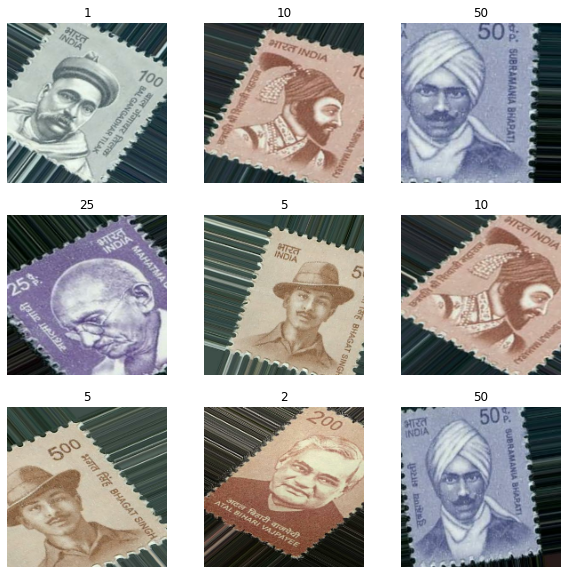

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9763658


Create the model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

Train the data

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 11s 1s/step - loss: 2.1348 - accuracy: 0.1810 - val_loss: 2.0127 - val_accuracy: 0.2222
Epoch 2/10
11/11 [==============================] - 10s 946ms/step - loss: 1.7600 - accuracy: 0.3650 - val_loss: 1.6827 - val_accuracy: 0.2099
Epoch 3/10
11/11 [==============================] - 10s 946ms/step - loss: 1.1150 - accuracy: 0.5982 - val_loss: 0.8940 - val_accuracy: 0.6296
Epoch 4/10
11/11 [==============================] - 11s 1s/step - loss: 0.6090 - accuracy: 0.7945 - val_loss: 0.6549 - val_accuracy: 0.7407
Epoch 5/10
11/11 [==============================] - 10s 953ms/step - loss: 0.3757 - accuracy: 0.8528 - val_loss: 0.5151 - val_accuracy: 0.8519
Epoch 6/10
11/11 [==============================] - 10s 951ms/step - loss: 0.2217 - accuracy: 0.9294 - val_loss: 0.3590 - val_accuracy: 0.9012
Epoch 7/10
11/11 [==============================] - 11s 961ms/step - loss: 0.1084 - accuracy: 0.9663 - val_loss: 0.3180 - val_accuracy: 0.8395
Epoch

Visualize training results

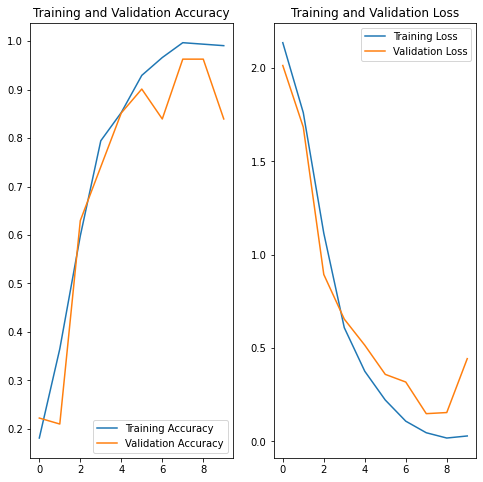

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Data Augmentation

Dropout

Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 11s 977ms/step - loss: 0.7779 - accuracy: 0.8221 - val_loss: 0.7093 - val_accuracy: 0.7778
Epoch 2/15
11/11 [==============================] - 10s 954ms/step - loss: 0.3000 - accuracy: 0.9018 - val_loss: 0.3406 - val_accuracy: 0.9136
Epoch 3/15
11/11 [==============================] - 10s 954ms/step - loss: 0.1428 - accuracy: 0.9847 - val_loss: 0.2627 - val_accuracy: 0.9506
Epoch 4/15
11/11 [==============================] - 10s 956ms/step - loss: 0.0570 - accuracy: 0.9969 - val_loss: 0.2176 - val_accuracy: 0.9506
Epoch 5/15
11/11 [==============================] - 10s 946ms/step - loss: 0.0236 - accuracy: 0.9969 - val_loss: 0.1671 - val_accuracy: 0.9506
Epoch 6/15
11/11 [==============================] - 10s 948ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1454 - val_accuracy: 0.9506
Epoch 7/15
11/11 [==============================] - 10s 951ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1383 - val_accuracy: 0.9506

Visualize training dataset

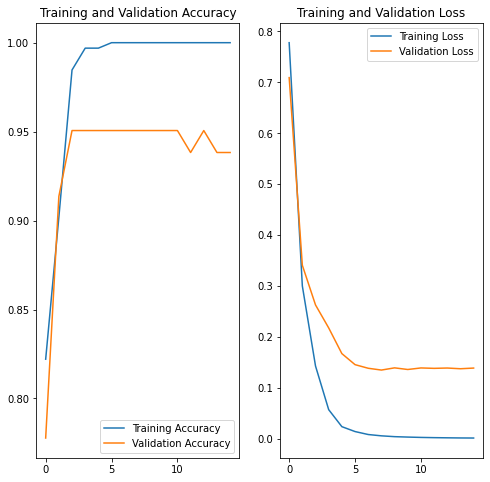

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 3 with a 99.98 percent confidence.
